https://webscope.sandbox.yahoo.com/

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from tqdm import tqdm
import tensorflow as tf
import edward as ed
from edward.models import Normal, Categorical
from subprocess import check_output
import matplotlib.pyplot as plt

ed.set_seed(12)
%matplotlib inline

In [19]:
train = pd.read_table('data/ydata-ymovies-user-movie-ratings-train-v1_0.txt', sep='\t', header = 0)
test = pd.read_table('data/ydata-ymovies-user-movie-ratings-test-v1_0.txt', sep='\t', header = 0)
demo = pd.read_table('data/ydata-ymovies-user-demographics-v1_0.txt', sep='\t', header = 0)
desc = pd.read_table('data/ydata-ymovies-movie-content-descr-v1_0.txt', sep='\t', header = 0)
movielens = pd.read_table('data/ydata-ymovies-mapping-to-movielens-v1_0.txt', sep='\t', header = 0)

In [24]:
train.head()

,1,1800029049,12,5
0,1,1804857429,8,4
1,1,1800030906,13,5
2,1,1800018548,11,5
3,1,1800256362,9,4
4,1,1808438656,9,4


In [4]:
data_x = data2.loc[:, 'cap-shape_b':].as_matrix().astype(np.float32)
data_y = data2.loc[:, :'class_p'].as_matrix().astype(np.float32)

N = 7000
train_x, test_x = data_x[:N], data_x[N:]
train_y, test_y = data_y[:N], data_y[N:]

in_size = train_x.shape[1]
out_size = train_y.shape[1]


# for bayesian neural network
train_y2 = np.argmax(train_y, axis=1)
test_y2 = np.argmax(test_y, axis=1)

In [5]:
EPOCH_NUM = 20
BATCH_SIZE = 1000

In [6]:
#build a bnn
x_ = tf.placeholder(tf.float32, shape=(None, in_size))
y_ = tf.placeholder(tf.int32, shape=(BATCH_SIZE))

In [7]:
#two-layer neural network.
def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.matmul(x, W_0) + b_0
    h = tf.tanh(h)
    #h = tf.exp(tf.negative(tf.square(h)))
    h = tf.matmul(h, W_1) + b_1
    return h

def display_draws(loss, train_x, EPOCH_NUM):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
    plt.plot(np.arange(EPOCH_NUM), train_loss / len(train_x), label='Train')
    plt.legend(fontsize=20)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('KL', fontsize=15)
    plt.show()

# Using GradientDescentOptimizer

In [8]:
EPOCH_NUM = 40
#batch sizes
small_batch = N/10
mid_batch = N/7
big_batch = N/5

learning_rate = 5e-3
#initialize losses
train_losssb = np.zeros(EPOCH_NUM)
train_lossmb = np.zeros(EPOCH_NUM)
train_lossbb = np.zeros(EPOCH_NUM)

In [9]:
BATCH_SIZE = small_batch
#build a bnn
x_ = tf.placeholder(tf.float32, shape=(None, in_size))
y_ = tf.placeholder(tf.int32, shape=(BATCH_SIZE))
w0 = Normal(loc=tf.zeros([in_size, out_size]), scale=tf.ones([in_size, out_size]))
b0 = Normal(loc=tf.zeros([out_size]), scale=tf.ones([out_size]))
w1 = Normal(loc=tf.zeros([out_size, in_size]), scale=tf.ones([out_size, in_size]))
b1 = Normal(loc=tf.zeros([in_size]), scale=tf.ones([in_size]))
y_pre =Categorical(neural_network(x_, w0,w1, b0, b1))
qw0 = Normal(loc=tf.Variable(tf.random_normal([in_size, out_size])), scale=tf.Variable(tf.random_normal([in_size, out_size])))
qb0 = Normal(loc=tf.Variable(tf.random_normal([out_size])), scale=tf.Variable(tf.random_normal([out_size])))
qw1 = Normal(loc=tf.Variable(tf.random_normal([out_size, in_size])), scale=tf.Variable(tf.random_normal([out_size, in_size])))
qb1 = Normal(loc=tf.Variable(tf.random_normal([in_size])), scale=tf.Variable(tf.random_normal([in_size])))
y =Categorical(neural_network(x_, qw0,qw1, qb0, qb1))

inference = ed.KLqp({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y_pre: y_})
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [10]:
with sess:
    samples_num = 100
    for epoch in tqdm(range(EPOCH_NUM), file=sys.stdout):
        perm = np.random.permutation(N)
        for i in range(0, N, BATCH_SIZE):
            batch_x = train_x[perm[i:i+BATCH_SIZE]]
            batch_y = train_y2[perm[i:i+BATCH_SIZE]]
            info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
        train_losssb[epoch] = info_dict['loss']
        y_samples = y.sample(samples_num).eval(feed_dict={x_: train_x})
        acc = (np.round(y_samples.sum(axis=0) / samples_num) == train_y2).mean()
        y_samples = y.sample(samples_num).eval(feed_dict={x_: test_x})
        test_acc = (np.round(y_samples.sum(axis=0) / samples_num) == test_y2).mean()
        if (epoch+1) % 10 == 0:
            tqdm.write('epoch:\t{}\taccuracy:\t{}\tvaridation accuracy:\t{}'.format(epoch+1, acc, test_acc))
sess.close()

epoch:	10	accuracy:	0.879571428571	varidation accuracy:	0.0569395017794
epoch:	20	accuracy:	0.550285714286	varidation accuracy:	0.343416370107
epoch:	30	accuracy:	0.694571428571	varidation accuracy:	0.45640569395
epoch:	40	accuracy:	0.575	varidation accuracy:	0.0836298932384
100%|██████████| 40/40 [00:16<00:00,  1.73it/s]


In [11]:
BATCH_SIZE = mid_batch
#build a bnn
x_ = tf.placeholder(tf.float32, shape=(None, in_size))
y_ = tf.placeholder(tf.int32, shape=(BATCH_SIZE))
w0 = Normal(loc=tf.zeros([in_size, out_size]), scale=tf.ones([in_size, out_size]))
b0 = Normal(loc=tf.zeros([out_size]), scale=tf.ones([out_size]))
w1 = Normal(loc=tf.zeros([out_size, in_size]), scale=tf.ones([out_size, in_size]))
b1 = Normal(loc=tf.zeros([in_size]), scale=tf.ones([in_size]))
y_pre =Categorical(neural_network(x_, w0,w1, b0, b1))
qw0 = Normal(loc=tf.Variable(tf.random_normal([in_size, out_size])), scale=tf.Variable(tf.random_normal([in_size, out_size])))
qb0 = Normal(loc=tf.Variable(tf.random_normal([out_size])), scale=tf.Variable(tf.random_normal([out_size])))
qw1 = Normal(loc=tf.Variable(tf.random_normal([out_size, in_size])), scale=tf.Variable(tf.random_normal([out_size, in_size])))
qb1 = Normal(loc=tf.Variable(tf.random_normal([in_size])), scale=tf.Variable(tf.random_normal([in_size])))
y =Categorical(neural_network(x_, qw0,qw1, qb0, qb1))

inference = ed.KLqp({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y_pre: y_})
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [12]:
with sess:
    samples_num = 100
    for epoch in tqdm(range(EPOCH_NUM), file=sys.stdout):
        perm = np.random.permutation(N)
        for i in range(0, N, BATCH_SIZE):
            batch_x = train_x[perm[i:i+BATCH_SIZE]]
            batch_y = train_y2[perm[i:i+BATCH_SIZE]]
            info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
        train_lossmb[epoch] = info_dict['loss']
        y_samples = y.sample(samples_num).eval(feed_dict={x_: train_x})
        acc = (np.round(y_samples.sum(axis=0) / samples_num) == train_y2).mean()
        y_samples = y.sample(samples_num).eval(feed_dict={x_: test_x})
        test_acc = (np.round(y_samples.sum(axis=0) / samples_num) == test_y2).mean()
        if (epoch+1) % 10 == 0:
            tqdm.write('epoch:\t{}\taccuracy:\t{}\tvaridation accuracy:\t{}'.format(epoch+1, acc, test_acc))
sess.close()

epoch:	10	accuracy:	0.534857142857	varidation accuracy:	0.4128113879
epoch:	20	accuracy:	0.534857142857	varidation accuracy:	0.4128113879
epoch:	30	accuracy:	0.715857142857	varidation accuracy:	0.73665480427
epoch:	40	accuracy:	0.884	varidation accuracy:	0.988434163701
100%|██████████| 40/40 [00:27<00:00,  1.31it/s]


In [13]:
BATCH_SIZE = big_batch
#build a bnn
x_ = tf.placeholder(tf.float32, shape=(None, in_size))
y_ = tf.placeholder(tf.int32, shape=(BATCH_SIZE))
w0 = Normal(loc=tf.zeros([in_size, out_size]), scale=tf.ones([in_size, out_size]))
b0 = Normal(loc=tf.zeros([out_size]), scale=tf.ones([out_size]))
w1 = Normal(loc=tf.zeros([out_size, in_size]), scale=tf.ones([out_size, in_size]))
b1 = Normal(loc=tf.zeros([in_size]), scale=tf.ones([in_size]))
y_pre =Categorical(neural_network(x_, w0,w1, b0, b1))
qw0 = Normal(loc=tf.Variable(tf.random_normal([in_size, out_size])), scale=tf.Variable(tf.random_normal([in_size, out_size])))
qb0 = Normal(loc=tf.Variable(tf.random_normal([out_size])), scale=tf.Variable(tf.random_normal([out_size])))
qw1 = Normal(loc=tf.Variable(tf.random_normal([out_size, in_size])), scale=tf.Variable(tf.random_normal([out_size, in_size])))
qb1 = Normal(loc=tf.Variable(tf.random_normal([in_size])), scale=tf.Variable(tf.random_normal([in_size])))
y =Categorical(neural_network(x_, qw0,qw1, qb0, qb1))

inference = ed.KLqp({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y_pre: y_})
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [14]:
with sess:
    samples_num = 100
    for epoch in tqdm(range(EPOCH_NUM), file=sys.stdout):
        perm = np.random.permutation(N)
        for i in range(0, N, BATCH_SIZE):
            batch_x = train_x[perm[i:i+BATCH_SIZE]]
            batch_y = train_y2[perm[i:i+BATCH_SIZE]]
            info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
        train_lossbb[epoch] = info_dict['loss']
        y_samples = y.sample(samples_num).eval(feed_dict={x_: train_x})
        acc = (np.round(y_samples.sum(axis=0) / samples_num) == train_y2).mean()
        y_samples = y.sample(samples_num).eval(feed_dict={x_: test_x})
        test_acc = (np.round(y_samples.sum(axis=0) / samples_num) == test_y2).mean()
        if (epoch+1) % 10 == 0:
            tqdm.write('epoch:\t{}\taccuracy:\t{}\tvaridation accuracy:\t{}'.format(epoch+1, acc, test_acc))
sess.close()

epoch:	10	accuracy:	0.467	varidation accuracy:	0.5871886121
epoch:	20	accuracy:	0.645571428571	varidation accuracy:	0.835409252669
epoch:	30	accuracy:	0.867857142857	varidation accuracy:	0.686832740214
epoch:	40	accuracy:	0.862142857143	varidation accuracy:	0.918149466192
100%|██████████| 40/40 [00:38<00:00,  1.02s/it]


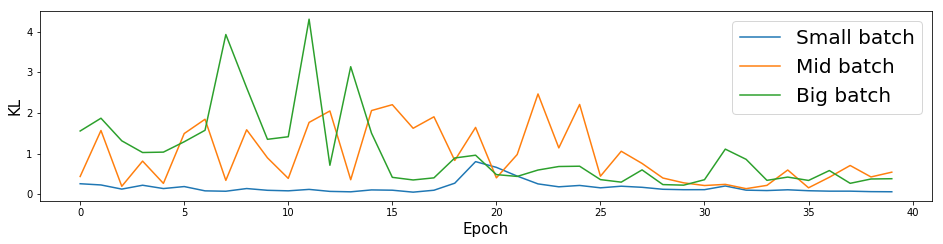

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(EPOCH_NUM), train_losssb / len(train_x), label='Small batch')
plt.plot(np.arange(EPOCH_NUM), train_lossmb / len(train_x), label='Mid batch')
plt.plot(np.arange(EPOCH_NUM), train_lossbb / len(train_x), label='Big batch')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('KL', fontsize=15)
plt.show()